#### Understanding Problem Statement

As a part of this problem, we are provided with the information about the stores (location, size, etc), products (weight, category, price, etc) and historical sales data. Using this information, we have to forecast the sales of the products in the stores.

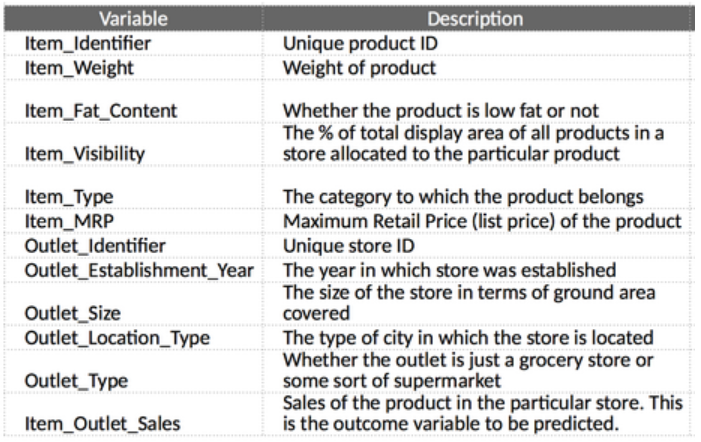

### Building a prototype model

To build a machine learning pipeline, the first requirement is to define the structure of the pipeline.

In order to do so, we will build a prototype machine learning model on the existing data before we create a pipeline. The main idea behind building a prototype is to understand the data and necessary preprocessing steps required before the model building process. Based on our learning from the prototype model, we will design a machine learning pipeline that covers all the essential preprocessing steps.

#### Data Exploration and Preprocessing

Let us start by checking if there are any missing values in the data. We will use the isnull().sum() function here

In [17]:
# importing required values
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# read the train data
train_data = pd.read_csv('D:\\Resolve6_Training\\DS_ML\\Sample Data Sets\\Big Mart Sales\\train_v9rqX0R.csv')

# check for the null values
train_data.isna().sum()

Item_Identifier                 0
Item_Weight                  1463
Item_Fat_Content                0
Item_Visibility                 0
Item_Type                       0
Item_MRP                        0
Outlet_Identifier               0
Outlet_Establishment_Year       0
Outlet_Size                  2410
Outlet_Location_Type            0
Outlet_Type                     0
Item_Outlet_Sales               0
dtype: int64

Since Item_Weight is a continuous variable, we can use either mean or median to impute the missing values. On the other hand, Outlet_Size is a categorical variable and hence we will replace the missing values by the mode of the column. 

In [18]:
# impute missing values in item weight by mean
train_data.Item_Weight.fillna(train_data.Item_Weight.mean(),inplace=True)
# impute outlet size in training data by mode
train_data.Outlet_Size.fillna(train_data.Outlet_Size.mode()[0],inplace=True)

Additionally, machine learning models cannot work with categorical (string) data as well, specifically scikit-learn. Before building a machine learning model, we need to convert the categorical variables into numeric types.

#### Encode the categorical variables

To check the categorical variables in the data, you can use the train_data.dtypes() function. 

In [19]:
import category_encoders as ce
# create an object of the OneHotEncoder
OHE = ce.OneHotEncoder(cols=['Item_Fat_Content',
                             'Item_Type',
                             'Outlet_Identifier',
                             'Outlet_Size',
                             'Outlet_Location_Type',
                             'Outlet_Type'],use_cat_names=True)
# encode the categorical variables
train_data = OHE.fit_transform(train_data)

c:\users\ajitabh\appdata\local\programs\python\python39\lib\site-packages\category_encoders\utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


#### Scale the data:

Next we will work with the continuous variables. Often the continuous variables in the data have different scales, for instance, a variable V1 can have a range from 0 to 1 while another variable can have a range from 0-1000.

In [20]:
from sklearn.preprocessing import StandardScaler
# create an object of the StandardScaler
scaler = StandardScaler()
# fit with the Item_MRP
scaler.fit(np.array(train_data.Item_MRP).reshape(-1,1))
# transform the data
train_data.Item_MRP = scaler.transform(np.array(train_data.Item_MRP).reshape(-1,1))

#### Model Building

Now that we are done with the basic pre-processing steps, we can go ahead and build simple machine learning models over this data. We will try two models here – Linear Regression and Random Forest Regressor to predict the sales.

To compare the performance of the models, we will create a validation set (or test set).

In [21]:
# importing libraries
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import  RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

# separate the independent and target variable 
train_X = train_data.drop(columns=['Item_Identifier','Item_Outlet_Sales'])
train_Y = train_data['Item_Outlet_Sales']

# randomly split the data
train_x, test_x, train_y, test_y = train_test_split(train_X, train_Y,test_size=0.25,random_state=0)

# shape of train and test splits
train_x.shape, test_x.shape, train_y.shape, test_y.shape

((6392, 45), (2131, 45), (6392,), (2131,))

Let us train a linear regression model on this data and check it’s performance on the validation set. To check the model performance, we are using RMSE as an evaluation metric.

In [22]:
# create an object of the LinearRegression Model
model_LR = LinearRegression()

# fit the model with the training data
model_LR.fit(train_x, train_y)

# predict the target on train and test data 
predict_train = model_LR.predict(train_x)
predict_test  = model_LR.predict(test_x)

# Root Mean Squared Error on train and test date
print('RMSE on train data: ', mean_squared_error(train_y, predict_train)**(0.5))
print('RMSE on test data: ',  mean_squared_error(test_y, predict_test)**(0.5))


RMSE on train data:  1122.568438679271
RMSE on test data:  1147.9617074712205


The linear regression model has a very high RMSE value on both training and validation data. Let us see if a tree-based model performs better in this case. Here we will train a random forest and check if we get any improvement in the train and validation errors.

In [23]:
# create an object of the RandomForestRegressor
model_RFR = RandomForestRegressor(max_depth=10)

# fit the model with the training data
model_RFR.fit(train_x, train_y)

# predict the target on train and test data
predict_train = model_RFR.predict(train_x)
predict_test = model_RFR.predict(test_x)

# Root Mean Squared Error on train and test data
print('RMSE on train data: ', mean_squared_error(train_y, predict_train)**(0.5))
print('RMSE on test data: ',  mean_squared_error(test_y, predict_test)**(0.5))

RMSE on train data:  895.0089388216029
RMSE on test data:  1115.05401519146


As you can see, there is a significant improvement on is the RMSE values. 

A very interesting feature of the random forest algorithm is that it gives you the ‘feature importance’ for all the variables in the data.

#### Feature Importance

After the preprocessing and encoding steps, we had a total of 45 features and not all of these may be useful in forecasting the sales. Alternatively we can select the top 5 or top 7 features, which had a major contribution in forecasting sales values.

The idea is to have a less complex model without compromising on the overall model performance.

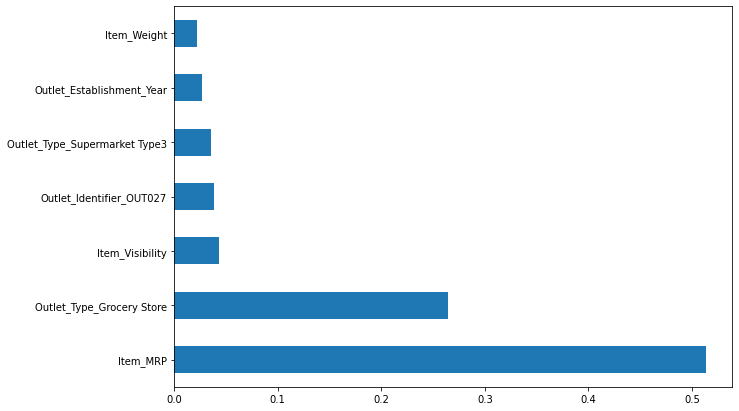

In [24]:
# plot the 7 most important features 
plt.figure(figsize=(10,7))
feat_importances = pd.Series(model_RFR.feature_importances_, index = train_x.columns)
feat_importances.nlargest(7).plot(kind='barh');

Now, we are going to train the same random forest model using these 7 features only and observe the change in RMSE values for the train and the validation set.

In [25]:
# training data with 7 most important features
train_x_if = train_x[['Item_MRP', 
                    'Outlet_Type_Grocery Store',
                    'Item_Visibility',
                    'Outlet_Type_Supermarket Type3',
                    'Outlet_Identifier_OUT027',
                    'Outlet_Establishment_Year',
                    'Item_Weight']]
# test data with 7 most important features
test_x_if = test_x[['Item_MRP', 
                    'Outlet_Type_Grocery Store',
                    'Item_Visibility',
                    'Outlet_Type_Supermarket Type3',
                    'Outlet_Identifier_OUT027',
                    'Outlet_Establishment_Year',
                    'Item_Weight']]

# create an object of the RandfomForestRegressor Model
model_RFR_with_if = RandomForestRegressor(max_depth=10,random_state=2)

# fit the model with the training data
model_RFR_with_if.fit(train_x_if, train_y)

# predict the target on the training and test data
predict_train_with_if = model_RFR_with_if.predict(train_x_if)
predict_test_with_if = model_RFR_with_if.predict(test_x_if)

# Root Mean Squared Error on the train and test data
print('RMSE on train data: ', mean_squared_error(train_y, predict_train_with_if)**(0.5))
print('RMSE on test data: ',  mean_squared_error(test_y, predict_test_with_if)**(0.5))


RMSE on train data:  899.8582438552844
RMSE on test data:  1117.7016540152065


Using only 7 features has given almost the same performance as the previous model where we were using 45 features.

### Pipeline Design

It is now time to form a pipeline design based on our learning from the last section. We will define our pipeline in three stages:

1.Create the required binary features
2.Perform required data preprocessing and transformations
3.Build a model to predict the sales

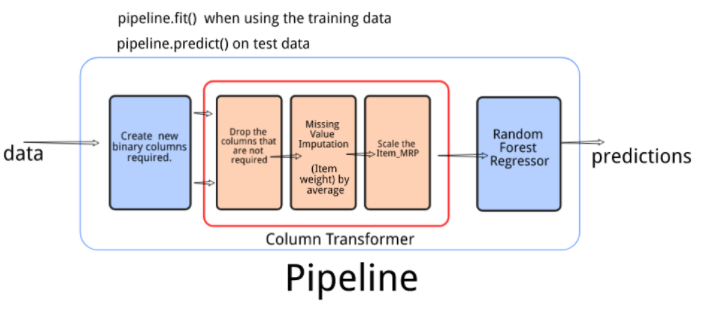

#### Building Pipeline

First of all, we will read the data set and separate the independent and target variable from the training dataset. 

In [26]:
# importing required libraries
import pandas as pd
from sklearn.compose import ColumnTransformer 
from sklearn.impute import SimpleImputer
import category_encoders as ce
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import Pipeline

# read the training data set
data = pd.read_csv('D:\\Resolve6_Training\\DS_ML\\Sample Data Sets\\Big Mart Sales\\train_v9rqX0R.csv')

# top rows of the data
data.head()

# seperate the independent and target variables
train_x = data.drop(columns=['Item_Outlet_Sales'])
train_y = data['Item_Outlet_Sales']

Now, as a first step, we need to create 3 new binary columns using a custom transformer. Here are the steps we need to follow to create a custom transformer.

Define a class OutletTypeEncoder
Add the parameter BaseEstimator while defining the class
The class must contain fit and transform methods

In [27]:
# import the BaseEstimator
from sklearn.base import BaseEstimator

# define the class OutletTypeEncoder
# This will be our custom transformer that will create 3 new binary columns
# custom transformer must have methods fit and transform
class OutletTypeEncoder(BaseEstimator):

    def __init__(self):
        pass

    def fit(self, documents, y=None):
        return self

    def transform(self, x_dataset):
        x_dataset['outlet_grocery_store'] = (x_dataset['Outlet_Type'] == 'Grocery Store')*1
        x_dataset['outlet_supermarket_3'] = (x_dataset['Outlet_Type'] == 'Supermarket Type3')*1
        x_dataset['outlet_identifier_OUT027'] = (x_dataset['Outlet_Identifier'] == 'OUT027')*1
        
        return x_dataset

Next we will define the pre-processing steps required before the model building process.

Drop the columns – Item_Identifier, Outlet_Identifier, Item_Fat_Content, Item_Type, Outlet_Identifier, Outlet_Size, Outlet_Location_Type and Outlet_Establishment_Year
Impute missing values in column Item_Weight with mean
Scale the column Item_MRP using StandardScaler().

In [28]:
# pre-processsing step
# Drop the columns - 
# Impute the missing values in column Item_Weight by mean
# Scale the data in the column Item_MRP
pre_process = ColumnTransformer(remainder='passthrough',
                                transformers=[('drop_columns', 'drop', ['Item_Identifier',
                                                                        'Outlet_Identifier',
                                                                        'Item_Fat_Content',
                                                                        'Item_Type',
                                                                        'Outlet_Identifier',
                                                                        'Outlet_Size',
                                                                        'Outlet_Location_Type',
                                                                        'Outlet_Type'
                                                                       ]),
                                              ('impute_item_weight', SimpleImputer(strategy='mean'), ['Item_Weight']),
                                              ('scale_data', StandardScaler(),['Item_MRP'])])


### Predict the target

This will be the final block of the machine learning pipeline – define the steps in order for the pipeline object

As you can see in the code below we have specified three steps – create binary columns, preprocess the data, train a model.

Post the model training process, we use the predict() function that uses the trained model to generate the predictions.

In [29]:
# Define the Pipeline
"""
Step1: get the oultet binary columns
Step2: pre processing
Step3: Train a Random Forest Model
"""
model_pipeline = Pipeline(steps=[('get_outlet_binary_columns', OutletTypeEncoder()), 
                                 ('pre_processing',pre_process),
                                 ('random_forest', RandomForestRegressor(max_depth=10,random_state=2))
                                 ])
# fit the pipeline with the training data
model_pipeline.fit(train_x,train_y)

# predict target values on the training data
model_pipeline.predict(train_x)

array([4348.01437159,  693.40276088, 2323.35268531, ..., 1300.83665376,
       1508.86795688, 1152.35475793])

Now, we will read the test data set and we call predict function only on the pipeline object to make predictions on the test data.

In [30]:
# read the test data
test_data = pd.read_csv('D:\\Resolve6_Training\\DS_ML\\Sample Data Sets\\Big Mart Sales\\test_AbJTz2l.csv')

# predict target variables on the test data 
model_pipeline.predict(test_data)

array([1646.0548363 , 1305.4298012 ,  658.42325097, ..., 1848.60226305,
       3959.67937864, 1384.01466986])

Having a well-defined structure before performing any task often helps in efficient execution of the same. And this is true even in case of building a machine learning model. Once you have built a model on a dataset, you can easily break down the steps and define a structured Machine learning pipeline.

In [31]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn import svm
pipeline_lr=Pipeline([('scalar1',StandardScaler()),
                     ('pca1',PCA(n_components=2)), 
                     ('lr_classifier',LogisticRegression())])
pipeline_dt=Pipeline([('scalar2',StandardScaler()),
                     ('pca2',PCA(n_components=2)),
                     ('dt_classifier',DecisionTreeClassifier())])
pipeline_svm = Pipeline([('scalar3', StandardScaler()),
                      ('pca3', PCA(n_components=2)),
                      ('clf', svm.SVC())])
pipeline_knn=Pipeline([('scalar4',StandardScaler()),
                     ('pca4',PCA(n_components=2)),
                     ('knn_classifier',KNeighborsClassifier())])
pipelines = [pipeline_lr, pipeline_dt, pipeline_randomforest, pipeline_knn]
pipe_dict = {0: 'Logistic Regression', 1: 'Decision Tree', 2: 'Support Vector Machine',3:'K Nearest Neighbor'}
for pipe in pipelines:
  pipe.fit(X_train, y_train)
for i,model in enumerate(pipelines):
    print("{} Test Accuracy:{}".format(pipe_dict[i],model.score(X_test,y_test)))

NameError: name 'PCA' is not defined